In [11]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
nlp = spacy.load("ru_core_news_sm")
df = pd.read_csv('data.csv')
print(df.head())

   Unnamed: 0                                            message
0           0  Привет! Я хочу заказать букет роз доставить в ...
1           1  Привет, хочу заказать доставку цветов в Новоси...
2           2  Здравствуйте, сколько стоит доставка цветов в ...
3           3  Здравствуйте, сколько стоит доставка цветов в ...
4           4  Привет! Хочу заказать цветы на день рождения п...


## Извлечение городов из набора данных с помощью Spacy 
Extracting the cities from the dataset using Spacy

In [13]:
def extract_city_spacy_dif(message):
    doc = nlp(message)
    cities = []
    for ent in doc.ents:
        if ent.label_ == 'LOC' and len(ent.text) > 2: 
            cities.append(ent.text)
    return cities

df['city_spacy'] = df['message'].apply(extract_city_spacy_dif)
df['city_spacy'] = df['city_spacy'].apply(lambda x: x[0] if x else None)
print(df[['message', 'city_spacy']])


                                               message     city_spacy
0    Привет! Я хочу заказать букет роз доставить в ...          Питер
1    Привет, хочу заказать доставку цветов в Новоси...    Новосибирск
2    Здравствуйте, сколько стоит доставка цветов в ...  Екатеринбурге
3    Здравствуйте, сколько стоит доставка цветов в ...            Екб
4    Привет! Хочу заказать цветы на день рождения п...           None
..                                                 ...            ...
115  Привет, доставите букет роз в г. екат? Срочно ...           None
116  Привет, сколько стоит доставка цветов в г. ниж...           None
117  Хочу цветы в Новосибирске. Скорее быстро сдела...   Новосибирске
118  Здравствуйте! Хочу заказать букет роз с достав...            Алм
119  Здравствуйте. Я хочу заказать цветы в Москву н...         Москву

[120 rows x 2 columns]


### Извлеченные города
Extracted cities

In [14]:
df['city_spacy'] = df['message'].apply(extract_city_spacy_dif)
for cities in df['city_spacy']:
    if cities:
        print(cities[0])
    else:
        print("No city found")


Питер
Новосибирск
Екатеринбурге
Екб
No city found
Нижнем
Астану
Нижнем Новгороде
Новосибирск
С-Петербург
Москве
Петербурге
Санкт-Петербурге
Москва
Екатеринбург
Алматы
Новосиб
Новосибирск
Новосибирске
Москва
Новосиб
Москва
Нижнем Новгороде
Нижний Новгород
Нижний Новгород
No city found
Питере
No city found
No city found
Нижний Новгород
Санкт-Петербург
Новосибирске
Новосибирске
Новосибирск
Новосиб
Новосиб
Питере
Москва
Новосибирск
Екатеринбург
Питер
Екатеринбург
Нижний Новгород
Москва
Москве
Нур-Султан
No city found
Москве
No city found
Нижний Новгород
Нижнем Новгороде
Санкт-Петербурге
Санкт-Петербурге
Екб
No city found
No city found
Астана
Екатеринбурге
Екатеринбург
No city found
Нур-Султан
Новосиб
Екатеринбург
Новосибирск
Нижнем Новгороде
Мск
Екатеринбург
Новосибирске
Алм
No city found
Москве
Москву
No city found
Нижний Новгород
екат
No city found
Нижний Новгород
Москву
No city found
Москве
Нижнем Новгороде
Екатеринбург
Новосиб
No city found
Н.Новгород
Санкт-Петербург
Нижний Новгород
No

In [15]:
city_counts = df['city_spacy'].value_counts()
print("Number of cities found:", len(city_counts))
print("\nCity Counts:")
print(city_counts)

Number of cities found: 30

City Counts:
city_spacy
[]                    22
[Нижний Новгород]     10
[Новосибирск]         10
[Екатеринбург]         8
[Новосиб]              8
[Нижнем Новгороде]     7
[Москве]               6
[Москва]               5
[Новосибирске]         5
[Санкт-Петербурге]     4
[Екатеринбурге]        4
[Москву]               3
[Екб]                  3
[Санкт-Петербург]      3
[екат]                 2
[Алм]                  2
[Питере]               2
[Нур-Султан]           2
[Питер]                2
[Петербурге]           2
[Алматы]               1
[Астана]               1
[Мск]                  1
[С-Петербург]          1
[Астану]               1
[Нижнем]               1
[Н.Новгород]           1
[Маскве]               1
[Москвы]               1
[Нижний-Новгород]      1
Name: count, dtype: int64


## Внедрение модели машинного обучения для прогнозирования
Implementing ML model to predict 

In [16]:

city_mappings = {
    'н. новгород': 'нижний новгород',
    'нижнем':'нижний новгород',
    'нижний новгород': 'нижний новгород',
    'новосибирск': 'новосибирск',
    'екатеринбург': 'екатеринбург',
    'нижнем новгороде': 'нижний новгород',
    'москве': 'москва',
    'москва': 'москва',
    'новосибирске': 'новосибирск',
    'екатеринбурге': 'екатеринбург',
    'санкт-петербурге': 'санкт-петербург',
    'екат': 'екатеринбург',
    'москву': 'москва',
    'санкт-петербург': 'санкт-петербург',
    'петербурге': 'санкт-петербург',
    'спб': 'санкт-петербург',
    'екб - город': 'екатеринбург',
    'новосиб': 'новосибирск',
    'питере': 'санкт-петербург',
    'питер': 'санкт-петербург',
    'с-петербург':'санкт-петербург',
    'астана': 'астана',
    'нур-султан': 'астана',
    'астану': 'астана',
    'екб': 'екатеринбург',
    'мск': 'москва',
    'маскве': 'москва',
    'москвы': 'москва',
    'нижний-новгород': 'нижний новгород',
    'алм': 'алматы',
}

def extract_city_spacy(message):
    doc = nlp(message)
    cities = []
    for ent in doc.ents:
        if ent.label_ == 'LOC' and ent.text.lower() in city_mappings and len(ent.text) > 2:
            cities.append(ent.text.lower())
    return cities

df['city_spacy'] = df['message'].apply(extract_city_spacy)
df['city_spacy_mapped'] = df['city_spacy'].apply(lambda x: [city_mappings[city] for city in x])
df['city_spacy_mapped'] = df['city_spacy_mapped'].apply(lambda x: x[0] if x else None)

df.dropna(subset=['city_spacy_mapped'], inplace=True)

X = df['message']
y = df['city_spacy_mapped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

new_messages_1 = [
    "Планирую путешествие в Санкт-Петербург на следующей неделе.",
    "Заказываю билеты на поезд в Екатеринбург на выходные.",
    "Ищу отель в Астане для предстоящей командировки.",
    "Покупаю билеты на автобус в Нижний Новгород на праздники.",
    "Нужен трансфер из аэропорта в Новосибирске до отеля.",
    "Планирую поездку в Алматы для участия в конференции.",
    "Мечтаю посетить Москву на следующих выходных.",
    "Ищу достопримечательности в Новосибирске для туристической поездки.",
    "Хочу заказать доставку цветов в Петербурге на день рождения друга."
]

new_messages_2 = [
    "Собираюсь отправиться в Екатеринбург на ближайшие выходные.",
    "Ищу гостиницу в Москве для предстоящей деловой встречи.",
    "Планирую экскурсию по достопримечательностям Санкт-Петербурга.",
    "Намечается деловая поездка в Астану на следующей неделе.",
    "Хочу посетить Нижний Новгород и познакомиться с его историей.",
    "Покупаю билеты на самолет в Новосибирск на новогодние каникулы.",
    "Ищу рестораны с местной кухней в Алматы.",
    "Планирую поездку в Санкт-Петербург на майские праздники.",
    "Ищу отель в Екатеринбурге с бассейном и спа-центром."
]


predicted_cities_1 = pipeline.predict(new_messages_1)
predicted_cities_2 = pipeline.predict(new_messages_2)

print("Predicted Cities:", predicted_cities_1, predicted_cities_2)


Accuracy: 0.6
Predicted Cities: ['санкт-петербург' 'екатеринбург' 'нижний новгород' 'нижний новгород'
 'екатеринбург' 'нижний новгород' 'москва' 'новосибирск' 'екатеринбург'] ['екатеринбург' 'москва' 'санкт-петербург' 'екатеринбург'
 'нижний новгород' 'нижний новгород' 'новосибирск' 'санкт-петербург'
 'екатеринбург']


### Матрица путаницы после прогнозирования
Post prediction confusion matrix

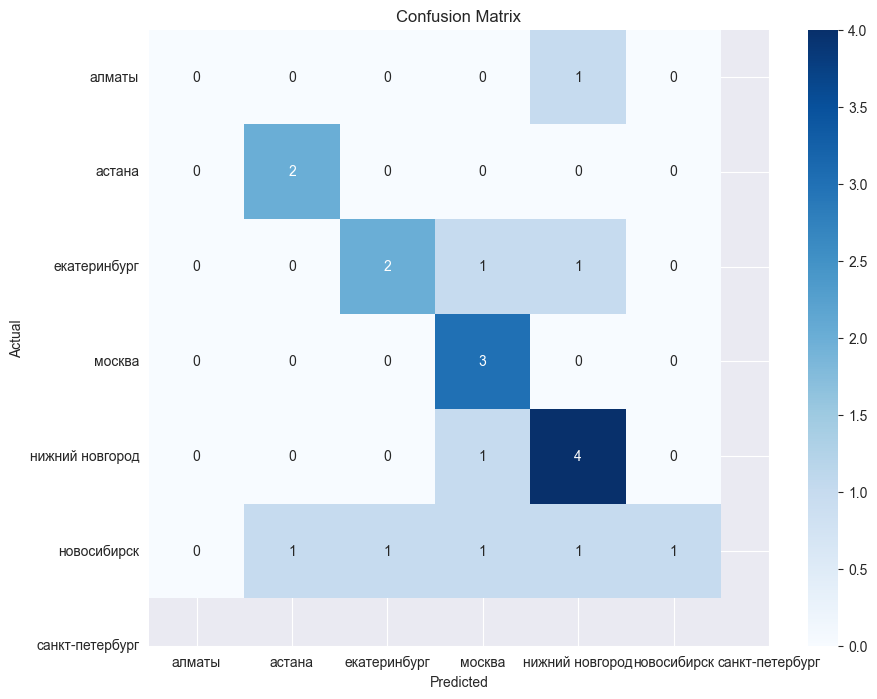

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


график, чтобы лучше понять прогноз

<Figure size 1200x800 with 0 Axes>

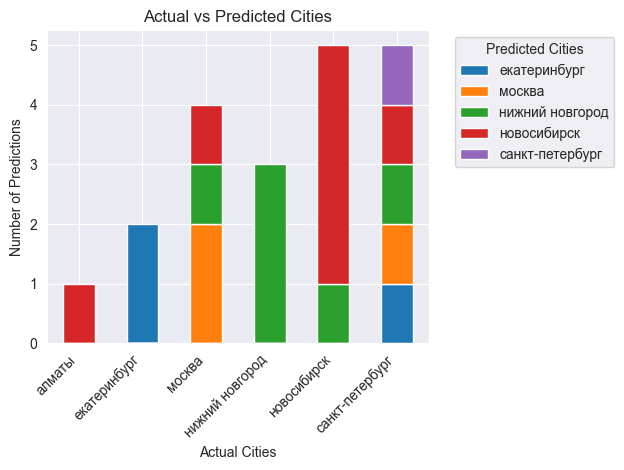

In [18]:
predicted_test = pipeline.predict(X_test)
actual_vs_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_test})

actual_vs_predicted['Predicted'] = actual_vs_predicted['Predicted'].map(city_mappings)
city_counts = actual_vs_predicted.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
city_counts.plot(kind='bar', stacked=True)
plt.xlabel('Actual Cities')
plt.ylabel('Number of Predictions')
plt.title('Actual vs Predicted Cities')
plt.legend(title='Predicted Cities', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Description | Описание
Я начал с загрузки данных из файла CSV и предварительной их обработки для извлечения названий городов, упомянутых в текстовых сообщениях, с помощью `spaCy`. Чтобы обрабатывать вариации названий городов, я создаю словарь для сопоставления различных представлений со стандартизированными названиями городов (для обучения ML). Затем я разделяю данные на обучающий и тестовый наборы. Используя `scikit-learn`, я создаю конвейер машинного обучения, состоящий из `CountVectorizer` для преобразования текста в числовые характеристики и `многочленного наивного байесовского классификатора (Multinomial Naive Bayes classifier)` для прогнозирования. После обучения модели на обучающих данных я оцениваю ее точность на тестовых данных (`new_messages_1` и `new_messages_2`). Для дальнейшего анализа эффективности модели я визуализирую результаты с помощью матрицы путаницы, которая помогает мне понять, насколько хорошо модель предсказывает названия городов.
Как видите, точность `0,6` предполагает, что модель правильно предсказывает названия городов в 60% случаев. Точность низкая из-за размера набора данных.